<a href="https://colab.research.google.com/github/astorguy/learn_ngspice/blob/main/notebooks/rlc/rlc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Set-up
Start with an empty directory; installs and imports.

In [ ]:
# Removes files and directories that may be there from previous runs
#   also gets rid of the ubiquitous "sample_data" directory
!rm -rf *

In [ ]:
!apt-get install -y ngspice # install ngspice
%pip install py4spice # Install pyspice package from PyPI

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ngspice is already the newest version (36+ds-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.


In [ ]:
from pathlib import Path
import py4spice

#Ngspice simulation of RLC

###Paths dictionary
There are paths and files to define. We're put them into a dictionary to keep things organized. Two subdirectories are also defined:
- netlists
- results

In [ ]:
paths = {}  # define empty paths dictionary
paths["ngspice"] = Path("/usr/bin/ngspice") # ngspice executable

paths["content"] = Path("/content")
paths["netlists"] = paths["content"] / "netlists"
paths["netlists"].mkdir(parents=True, exist_ok=True) # create netlist directory if does not exist
paths["results"] = paths["content"] / "results"
paths["results"].mkdir(parents=True, exist_ok=True) # create results directory if does not exist

We need to create a file for the simulation transcript.

In [ ]:
# create simulation transcript file. If it exists, make sure it is empty
paths["sim_transcript"] = paths["results"] / "sim_transcript.log"
if paths["sim_transcript"].exists():  # delete, recreate.
    paths["sim_transcript"].unlink()
paths["sim_transcript"].touch()

In [ ]:
netlists = {}  # define empty netlists dictionary

# create these lines to use when concatenating to make the top netlist
netlists["blankline"] = py4spice.Netlist("")  # blank line for spacing
netlists["title"] = py4spice.Netlist("* RLC Analysis")
netlists["end_line"] = py4spice.Netlist(".end")

###Creating DUT (Device Under Test)
Though this circuit is simple, we are going to separate the DUT from all the other parts of the netlist. The simulations, title, and `.end` lines will be added separately.

We want to measure the current through the capacitor and the inductor. Therefore, we do the old spice trick of adding 0 volt source in series. (Ugly, but effective)

In [ ]:
dut_contents = """
r1 out 0 100
l1 out lmid 10e-6 ic=300e-3
vil lmid 0 dc 0
c1 out cmid 10e-9
vic cmid 0 dc 0
""".strip()

netlists["dut"] = py4spice.Netlist(dut_contents)

###Vectors dictionary
Vectors objects are used to define a set of circuit signals to create and display. Again, we put them into a dictionary to keep things organized.

In [ ]:
vectors = {}   # start with empty vectors dictionary
vectors["all"] = py4spice.Vectors("all") # this is reserved word for Ngspice
vectors["out"] = py4spice.Vectors("out")
vectors["vil#branch"] = py4spice.Vectors("vil#branch")
vectors["vic#branch"] = py4spice.Vectors("vic#branch")
vectors["currents"] = vectors["vil#branch"] + vectors["vic#branch"]
vectors["I_capacitor"] = py4spice.Vectors("I_capacitor") # rename for nice plots
vectors["I_inductor"] = py4spice.Vectors("I_inductor") # rename for nice plots
vectors["currents_renamed"] = vectors["I_capacitor"] + vectors["I_inductor"]

###Analyses to run during the simulation process
Each batch simulation in Ngspice can perform one or more analyses. We will create a list of analyses to make it easier to reuse the code. The Analysis object has the following arguments:

| Argument | Description |
| :--- | :--- |
| **name** | Label given to the object. |
| **cmd_type** | Ngspice has different types of analyses. The `op`, `tran`, `ac`, and `dc` analyses are supported with `py4spice`. |
| **cmd** | This is the actual command that will be sent to Ngspice. Its arguments can be found in the Ngspice documentation. |
| **vector** | This defines which signals will be in the simulation results. |
| **results_loc** | Where to put the results files. |

In [ ]:
list_of_analyses = []  # start with an empty list

# 1st analysis: operating point
tran1 = py4spice.Analyses(
    name="tran1",
    cmd_type="tran",
    cmd="tran 1e-9 5e-6 uic",
    vector=vectors["all"],
    results_loc=paths["results"],
)
list_of_analyses.append(tran1)


###Control section
This is the section that tells Ngspice what operations to do. A netlist object snippet is created. It will be concatenated with the other netlist objects to create the top-level netlist.

In [ ]:
my_control = py4spice.Control()  # create 'my_control' object

# add all the analyses defined above into the control section
for analysis in list_of_analyses:
    my_control.insert_lines(analysis.lines_for_cntl())

# convert control section into a netlist object
netlists["control1"] = py4spice.Netlist(str(my_control))

###Create a single netlist, ready for simulation
The netlist snippets are concatenated and merged into `top`. `top.cir` is written out. It will be read in during the simulation. We print out `top` to verify everything is correct.

In [ ]:
# concatenate all tne netlists to make top1 and add to netlist dict
netlists["top"] = (
    netlists["title"]
    + netlists["blankline"]
    + netlists["dut"]
    + netlists["blankline"]
    + netlists["control1"]
    + netlists["blankline"]
    + netlists["end_line"]
    + netlists["blankline"]
    )

# write netlist to a file so ngspice can read it
paths["top"] = paths["netlists"] / "top.cir"
netlists["top"].write_to_file(paths["top"])

# here is the netlist in top.cir and will be used for simulation
print(netlists["top"])

* rlc analysis

r1 out 0 100
l1 out lmid 10e-6 ic=300e-3
vil lmid 0 dc 0
c1 out cmid 10e-9
vic cmid 0 dc 0

.control
* timestamp: sat jan 31 19:47:02 2026
set wr_singlescale  $ makes one x-axis for wrdata
set wr_vecnames     $ puts names at top of columns
tran 1e-9 5e-6 uic
wrdata /content/results/tran1.txt all
quit
.endc

.end



###Simulate
The Ngspice command is constructed, printed out for verification, and executed. `timeout` (in seconds) is set in case the simulation hangs.

In [ ]:
# prepare simulate object and simulate
sim = py4spice.Simulate(
    ngspice_exe=paths["ngspice"],
    netlist_filename=paths["top"],
    transcript_filename=paths["sim_transcript"],
    name="sim1",
    timeout=5,
)
# print out the command that will be used in the spawned process
print(sim.ngspice_command)

sim.run()  # run the Ngspice simulation

['/usr/bin/ngspice', '-b', '/content/netlists/top.cir']


###Create simResults objects
The raw results we get from Ngspice are large text files. We convert these to py4spice simResults objects so we can easily manipulate and display.

In [ ]:
sim_results: list[py4spice.SimResults] = [
    py4spice.SimResults.from_file(analysis.cmd_type, analysis.results_filename)
    for analysis in list_of_analyses
]

###Create Waveforms
Create waveforms from simulation data

In [ ]:
# prepare waveform for current through inductor
out_waves = py4spice.Waveforms(sim_results[0].header, sim_results[0].data_plot)
out_waves.vec_subset(vectors["currents"].list_out())
out_waves.scaler(1.0, "vil#branch", "I_inductor")  # rename
out_waves.scaler(1.0, "vic#branch", "I_capacitor")  # rename

###Plot
Right-click on plot and "Open image in new tab"

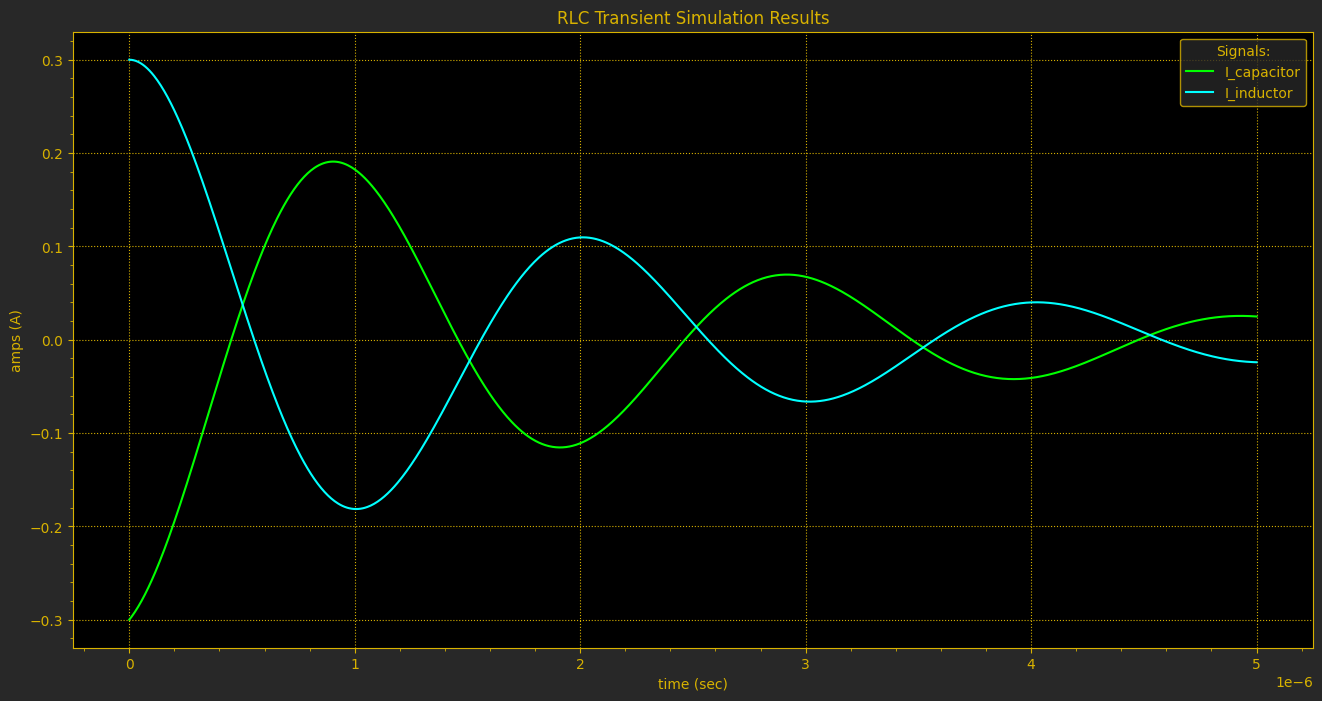

In [ ]:
plot_data = out_waves.x_axis_and_sigs(vectors["currents_renamed"].list_out())
y_names = vectors["currents_renamed"].list_out()
my_plt = py4spice.Plot("tr_plt", plot_data, y_names, paths["results"])
my_plt.set_title("RLC Transient Simulation Results")
my_plt.define_axes(("time", "sec", "linear"), ("amps", "A", "linear"))